# Portfolio summary statistics

[Returns and volatility](#r_vol)
- [Annualized return](#r_ann)
- [Annualized volatility](#vol_ann)
- [Sharpe ratio](#sharpe)
- [Covariance matrix](#cov)
- [Drawdown](#dd)

[Distribution of Returns](#distrib)
- [Skewness](#skew)
- [Kurtosis](#kurt)
- [Value at Risk](#VaR)
    - [Historic VaR](#hVaR)
    - [Gaussian VaR](#gVaR)
    - [Cornish-Fisher VaR](#cfVaR)
    - [Conditional VaR (expected shortfall)](#CVaR)

[Summary stats](#summary)

[Testing the module](#mod)

In [1]:
import pandas as pd
import numpy as np

---

In [2]:
df_cac40 = pd.read_pickle('./cac40_data/df_cac40.pkl')
df_cac40_rets = df_cac40.pct_change().dropna() # drop 1st line containing NaNs

df_cac40_stocks = pd.read_pickle('./cac40_data/df_cac40_stocks.pkl')
df_cac40_stocks_rets = df_cac40_stocks.pct_change().dropna()

## Returns and volatility <a id='r_vol'></a>

### Annualized return  <a id='r_ann'></a>

$\Pi_{i=1}^N (1+r_i)$ is the compounded growth over N days, where $r_i$ is the daily returns for day $i$ .

If $N=252$ (1 year), then the annualized return $r_{ann}$ verifies: $1+r_{ann}=\Pi_{i=1}^N (1+r_i)$

For $N = 2\times252$ days (2 years), then daily growth is compounded $2$ years, such that: $(1+r_{ann})^2=\Pi_{i=1}^{N} (1+r_i)$

For $N = x\times252$ days (x years), then daily growth is compounded $x$ years, such that: $(1+r_{ann})^x=\Pi_{i=1}^{N} (1+r_i)$. 

Substituting $x$ for $N$, the annualized return can also be written :$(1+r_{ann})^{N/252}=\Pi_{i=1}^{N} (1+r_i)$, or: $$r_{ann}=(\Pi_{i=1}^{N} (1+r_i))^{252/N} - 1$$


In [3]:
def annualize_rets(r, periods_per_year):
    """
    Annualizes a set of returns
    r is either a pandas DataFrame or a pandas Series containing a time history of returns
    periods_per_year = 252 for daily returns, 12 for monthly returns, etc.
    """
    compounded_growth = (1+r).prod()
    n_periods = r.shape[0]
    return compounded_growth**(periods_per_year/n_periods) - 1

In [4]:
rets = annualize_rets(df_cac40_stocks_rets, 252) # annualized returns for each asset
rets.head(3)

AI.PA     0.132839
AIR.PA    0.102659
ALO.PA   -0.122198
dtype: float64

##### Using annualized returns to calculate portfolio's return

In [5]:
def portfolio_return(weights, returns):
    """
    Computes the return on a portfolio from constituent returns and weights.
    weights are a numpy array or Nx1 matrix and returns are a numpy array or Nx1 matrix.
    """
    return weights.T @ returns


Equal weights portfolio return

In [6]:
n = rets.shape[0]
weights = np.repeat(1/n, n) # equal weights
portfolio_return(weights, rets)

0.0030221789893275317

### Annualized volatility  <a id='vol_ann'></a>
Price is continuously compounded : $P_t=P_{t-1}e^{r_t}$, where $r_t \sim N(\mu,\sigma^2)$, so $P_t$ follows a **geometric** random walk.

However, return $r_t = \mu + \epsilon_t$ (where $\epsilon \sim N(0,\sigma^2)$) follows an **arithmetic** random walk.

Therefore all random walks of $r$ are independent, so that for 2 random walks: $\text{Var}(r_t + r_{t'}) = \text{Var}(r_t) + \text{Var}(r_{t'}) + 2\text{Cov}(r_t, r_{t'}) = \sigma^2 + \sigma^2 = 2\sigma^2$

And more generally, $\text{Var}(r_{1}+...+r_{T}) = T\sigma^2$ leading to $$\sigma_T = \sqrt{T}\sigma$$

In [7]:
def annualize_vol(r, periods_per_year):
    """
    Annualizes the volatility of a set of returns.
    """
    return r.std()*(periods_per_year**0.5)

In [8]:
vols = annualize_vol(df_cac40_stocks_rets, 252) # annualized volatilities for each asset
vols.head(3)

AI.PA     0.209176
AIR.PA    0.316367
ALO.PA    0.393407
dtype: float64

### Sharpe ratio  <a id='sharpe'></a>
Sharpe ratio measures return over risk using annualized quantities:
$$\lambda=\frac{r_{ann} - r_{riskfree}}{\sigma_{ann}}$$

In [9]:
def sharpe_ratio(r, annual_riskfree_rate, periods_per_year):
    """
    Computes the annualized sharpe ratio of a set of returns.
    r is given for an arbitrary period, while risk free rate is ususally already annualized
    """
    # convert the annual riskfree rate to per period,
    # amounts to reversing the annualization operation
    rf_per_period = (1+annual_riskfree_rate)**(1/periods_per_year)-1
    # difference r-rf can now be calculated since both r and rf have the same time resolution
    excess_ret = r - rf_per_period
    # Now, re-annualize enverything:
    # annualize (r-rf)
    ann_ex_ret = annualize_rets(excess_ret, periods_per_year)
    # annualize volatility
    ann_vol = annualize_vol(r, periods_per_year)
    return ann_ex_ret/ann_vol

In [10]:
sharpe = sharpe_ratio(df_cac40_stocks_rets, 0, 252)
sharpe.head(3)

AI.PA     0.635061
AIR.PA    0.324493
ALO.PA   -0.310616
dtype: float64

### Covariance matrix  <a id='cov'></a>

In [11]:
cov = df_cac40_stocks_rets.cov() # covariance matrix of assets returns

##### Using covariance matrix to calculate portfolio's volatility

In [12]:
def portfolio_vol(weights, covmat):
    """
    Computes the vol of a portfolio from a covariance matrix and constituent weights.
    weights are a numpy array or N x 1 maxtrix and covmat is an N x N matrix.
    """
    return (weights.T @ covmat @ weights)**0.5

In [13]:
portfolio_vol(weights, cov)

0.01174753721487252

### Drawdown  <a id='dd'></a>

In [14]:
def drawdown(return_series: pd.Series):
    """Takes a time series of asset returns.
       returns a DataFrame with columns for the wealth index, the previous peaks, and 
       the percentage drawdown
    """
    wealth_index = (1+return_series).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks
    return pd.DataFrame({"Wealth": wealth_index, 
                         "Previous Peak": previous_peaks, 
                         "Drawdown": drawdowns})

<Axes: >

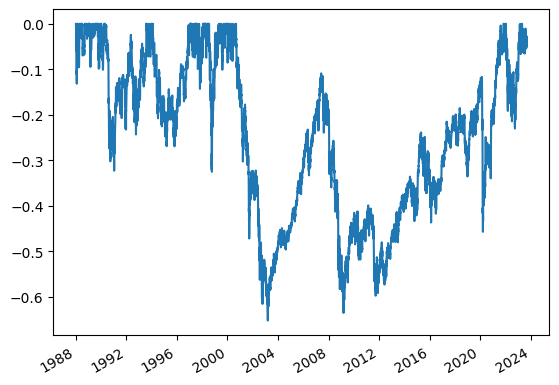

In [15]:
drawdown(df_cac40_rets['cac40_index'])['Drawdown'].plot()

## Distribution of Returns <a id='distrib'></a>

array([[<Axes: title={'center': 'cac40_index'}>]], dtype=object)

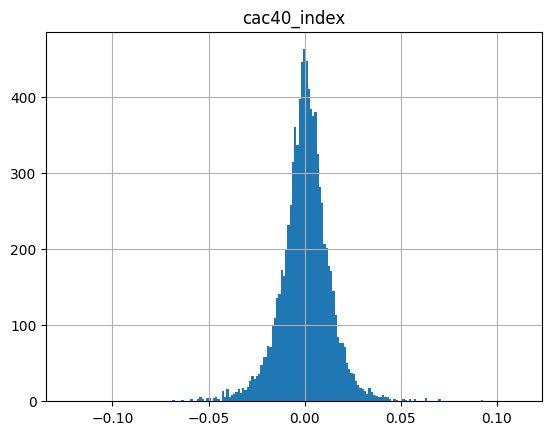

In [16]:
df_cac40_rets.hist(bins=200)

### Skewness <a id='skew'></a>

The skewness is given by:

$$ S(R) = \frac{E[ (R-E(R))^3 ]}{\sigma_R^3} $$

In [17]:
df_cac40_rets.skew() # pandas method

cac40_index   -0.050412
dtype: float64

In [67]:
def skewness(r):
    """
    Wrap pandas method into a fnuction that vcan be used with a Series or DataFrame
    """
    
    return r.skew()


In [65]:
def skewness(r):
    """
    Alternative to scipy.stats.skew()
    Computes the skewness of the supplied Series or DataFrame
    Returns a float or a Series
    """
    demeaned_r = r - r.mean()
    # use the population standard deviation, so set dof=0
    sigma_r = r.std(ddof=0)
    exp = (demeaned_r**3).mean()
    return exp/sigma_r**3


In [73]:
df_cac40_stocks_rets['AI.PA'].skew()

0.39746436193471657

### Kurtosis<a id='kurt'></a>

Pandas calculates the excess Kurtosis (=0 for a Normal distribution) given by:

$$ K(R) = \frac{E[ (R-E(R))^4 ]}{\sigma_R^4} - 3 $$

In [18]:
df_cac40_rets.kurtosis() # pandas method

cac40_index    5.768267
dtype: float64

### Value at Risk<a id='VaR'></a>

#### Historic VaR<a id='hVaR'></a>

Historic VaR uses the historic distributions of returns. The time during which the returns were acquired must be specified (1-month VaR, 1-year VaR...)

The VaR at 5% is the value of the return such that 5% of the returns fall below that value and 95% of the returns fall above that value. 

In other words, VaR is minus the 5 percentile return (minus on order to have a positive number representative of the loss)

In [19]:
def var_historic(r, level=5):
    """
    Returns the historic Value at Risk at a specified level
    i.e. returns the number such that "level" percent of the returns
    fall below that number, and the (100-level) percent are above
    """
    if isinstance(r, pd.DataFrame):
        return r.aggregate(var_historic, level=level)
    elif isinstance(r, pd.Series):
        return -np.percentile(r, level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")


In [20]:
var_historic(df_cac40_rets, level=5)

cac40_index    0.020847
dtype: float64

=> The bottom 5% returns are below the value -2.0847%. There is a 5% chance that the returns will be below -2.0847%.

In [21]:
var_historic(df_cac40_rets, level=1)

cac40_index    0.038255
dtype: float64

=> The bottom 1% returns are below the value -3.8255%.

In [22]:
np.percentile(df_cac40_rets.values, 5)

-0.020846578018704265

### Conditional VaR<a id='CVaR'></a>

CVaR = average of all returns which are worse than the VaR

In [23]:
def cvar_historic(r, level=5):
    """
    Computes the Conditional VaR of Series or DataFrame
    """
    if isinstance(r, pd.Series):
        is_beyond = r <= -var_historic(r, level=level)
        return -r[is_beyond].mean()
    elif isinstance(r, pd.DataFrame):
        return r.aggregate(cvar_historic, level=level)
    else:
        raise TypeError("Expected r to be a Series or DataFrame")

In [24]:
cvar_historic(df_cac40_rets)

cac40_index    0.031468
dtype: float64

In [27]:
cvar_historic(df_cac40_stocks_rets).head(3)

AI.PA     0.027644
AIR.PA    0.045113
ALO.PA    0.059557
dtype: float64

### Gaussian VaR<a id='gVaR'></a>

To avoid sample bias from historical returns... we take the samples and assume these have a gaussian distribution, in which case calculating the VaR boils down to the z-score

### Cornish-Fisher VaR<a id='cfVaR'></a>

Gaussian VaR underestimates the VaR because of the thin tails of the Gaussian, so we now have model bias. Cornish-Fisher VaR adds some correction to the z-score by taking into account higher order moments of the distribution (skewness and kurtosis).

In [29]:
from scipy.stats import norm
def var_gaussian(r, level=5, modified=False):
    """
    Returns the Parametric Gaussian VaR of a Series or DataFrame
    If "modified" is True, then the modified VaR is returned,
    using the Cornish-Fisher modification
    """
    # compute the Z score assuming it was Gaussian = # of std deviations from the mean
    z = norm.ppf(level/100) # percent point function for a Normal distrib
    if modified:
        # modify the Z score based on observed skewness and kurtosis
        s = r.skew()
        k = r.kurtosis() # excess kurtosis
        z = (z +
                (z**2 - 1)*s/6 +
                (z**3 -3*z)*(k)/24 -
                (2*z**3 - 5*z)*(s**2)/36
            )
    return -(r.mean() + z*r.std(ddof=0))

In [30]:
var_gaussian(df_cac40_rets, level=5, modified=True)

cac40_index    0.020418
dtype: float64

In [31]:
var_gaussian(df_cac40_rets, level=5, modified=False)

cac40_index    0.02179
dtype: float64

In [33]:
var_gaussian(df_cac40_stocks_rets, modified=True).head(3)

AI.PA     0.018859
AIR.PA    0.032004
ALO.PA    0.039985
dtype: float64

## Summary stats <a id='summary'></a>

In [77]:
def summary_stats(r, riskfree_rate=0.03, periods_per_year=12):
    """
    Return a DataFrame that contains aggregated summary stats for the returns in the columns of r
    """
    ann_r = r.aggregate(annualize_rets, periods_per_year=periods_per_year)
    ann_vol = r.aggregate(annualize_vol, periods_per_year=periods_per_year)
    ann_sr = r.aggregate(sharpe_ratio, annual_riskfree_rate=riskfree_rate, periods_per_year=periods_per_year)
    dd = r.aggregate(lambda r: drawdown(r).Drawdown.min())
    skew = r.skew()
    kurt = r.kurtosis()
    cf_var5 = r.aggregate(var_gaussian, modified=True)
    hist_cvar5 = r.aggregate(cvar_historic)
    return pd.DataFrame({
        "Annualized Return": ann_r,
        "Annualized Vol": ann_vol,
        "Skewness": skew,
        "Kurtosis": kurt,
        "Sharpe Ratio": ann_sr,
        "Max Drawdown": dd,
        "Cornish-Fisher VaR (5%)": cf_var5,
        "Historic CVaR (5%)": hist_cvar5,
    })


In [78]:
summary_stats(df_cac40_rets, riskfree_rate=0.01, periods_per_year=252)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Sharpe Ratio,Max Drawdown,Cornish-Fisher VaR (5%),Historic CVaR (5%)
cac40_index,0.056485,0.213286,-0.050412,5.768267,0.215795,-0.652857,0.020418,0.031468


## Testing the module <a id='mod'></a>

In [81]:
import finance_utils as fin
%load_ext autoreload
%autoreload 2


In [35]:
rets = fin.annualize_rets(df_cac40_stocks_rets, 252) # annualized returns for each asset
rets.head(3)

AI.PA     0.132839
AIR.PA    0.102659
ALO.PA   -0.122198
dtype: float64

In [36]:
n = rets.shape[0]
weights = np.repeat(1/n, n) # equal weights
fin.portfolio_return(weights, rets)

0.0030221789893275317

In [37]:
vols = fin.annualize_vol(df_cac40_stocks_rets, 252) # annualized volatilities for each asset
vols.head(3)

AI.PA     0.209176
AIR.PA    0.316367
ALO.PA    0.393407
dtype: float64

In [38]:
sharpe = fin.sharpe_ratio(df_cac40_stocks_rets, 0, 252)
sharpe.head(3)

AI.PA     0.635061
AIR.PA    0.324493
ALO.PA   -0.310616
dtype: float64

In [39]:
cov = df_cac40_stocks_rets.cov() # covariance matrix of assets returns
fin.portfolio_vol(weights, cov)

0.01174753721487252

<Axes: >

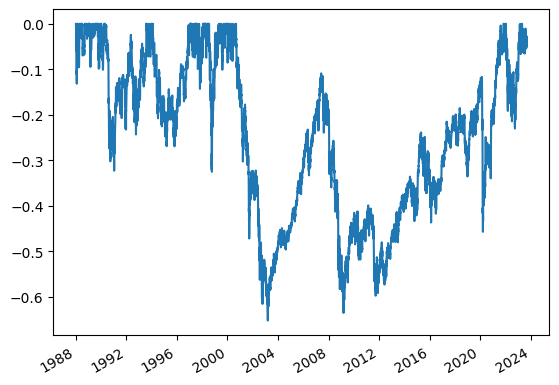

In [40]:
fin.drawdown(df_cac40_rets['cac40_index'])['Drawdown'].plot()

In [41]:
fin.var_historic(df_cac40_rets, level=5)

cac40_index    0.020847
dtype: float64

In [42]:
fin.var_historic(df_cac40_rets, level=1)

cac40_index    0.038255
dtype: float64

In [43]:
fin.cvar_historic(df_cac40_rets)

cac40_index    0.031468
dtype: float64

In [45]:
fin.cvar_historic(df_cac40_stocks_rets).head(3)

AI.PA     0.027644
AIR.PA    0.045113
ALO.PA    0.059557
dtype: float64

In [46]:
fin.var_gaussian(df_cac40_rets, level=5, modified=True)

cac40_index    0.020418
dtype: float64

In [47]:
fin.var_gaussian(df_cac40_rets, level=5, modified=False)

cac40_index    0.02179
dtype: float64

In [49]:
fin.var_gaussian(df_cac40_stocks_rets).head(3)

AI.PA     0.021071
AIR.PA    0.032162
ALO.PA    0.040933
dtype: float64

In [83]:
fin.summary_stats(df_cac40_rets, riskfree_rate=0.01, periods_per_year=252)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Sharpe Ratio,Max Drawdown,Cornish-Fisher VaR (5%),Historic CVaR (5%)
cac40_index,0.056485,0.213286,-0.050412,5.768267,0.215795,-0.652857,0.020418,0.031468


In [84]:
fin.summary_stats(df_cac40_stocks_rets, riskfree_rate=0.01, periods_per_year=252)

,Annualized Return,Annualized Vol,Skewness,Kurtosis,Sharpe Ratio,Max Drawdown,Cornish-Fisher VaR (5%),Historic CVaR (5%)
AI.PA,0.132839,0.209176,0.397464,2.581616,0.581459,-0.231740,0.018859,0.027644
AIR.PA,0.102659,0.316367,-0.292061,4.427413,0.289989,-0.268356,0.032004,0.045113
ALO.PA,-0.122198,0.393407,-0.036833,2.414248,-0.332727,-0.537132,0.039985,0.059557
MT,-0.058403,0.410544,0.002211,1.671317,-0.164980,-0.467543,0.041514,0.058757
CS.PA,0.108000,0.248958,-0.271207,4.361967,0.389756,-0.291130,0.025048,0.037837
BNP.PA,0.069224,0.317718,-0.459557,3.483522,0.184560,-0.386126,0.033549,0.050006
EN.PA,-0.056110,0.198714,-0.798860,3.159657,-0.329412,-0.283594,0.022613,0.031669
CAP.PA,-0.055859,0.309499,0.290597,1.904672,-0.210700,-0.298343,0.029688,0.040612
CA.PA,0.065906,0.252088,-0.150927,3.448684,0.219581,-0.337978,0.025285,0.037823
ACA.PA,0.000176,0.287508,-0.640496,5.976137,-0.033837,-0.423979,0.030568,0.047130
